## C3S.db Analysis
### _Analysis of the composition and characteristics of the C3S.db CCS database (as of 2019/07/19)_
#### Dylan H. Ross

In [49]:
# setup...
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from matplotlib import patches as mpatches
from matplotlib import rcParams

rcParams['font.size'] = 6


from C3SData.data import C3SD

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

import numpy as np

from scipy.stats import linregress


### PCA on all Molecular Descriptors
First, we will compute a PCA using all 42 MQNs, in addition to the m/z and encoded MS adduct and including all datasets. 

In [50]:
# initialize a full dataset
c3sd = C3SD('C3S.db', seed=12345)
c3sd.featurize()

print('X_ shape:', c3sd.X_.shape)
print('y_ shape:', c3sd.y_.shape)
print('features:', c3sd.n_features_)


X_ shape: (6042, 50)
y_ shape: (6042,)
features: 50


There are 50 features in total in the complete feature set. These are (in order):
* m/z
* one-hot encoded MS adduct (7 features)
* MQNs as described in Nguyen et al. ChemMedChem 4:1803-5 (2009) (42 features)
![MQNs](mqns.png)

In [51]:
# compute a 3-component PCA on the complete database using the full feature set
# use the StandardScaler to center and scale the data first
ss = StandardScaler()
X_scaled = ss.fit_transform(c3sd.X_)
pca = PCA(n_components=3)
pc1, pc2, pc3 = pca.fit_transform(X_scaled).T
pc1_evr, pc2_evr, pc3_evr = pca.explained_variance_ratio_
print('explained variance:')
print('    PC1: {:.1f} %'.format(pc1_evr * 100))
print('    PC2: {:.1f} %'.format(pc2_evr * 100))
print('    PC3: {:.1f} %'.format(pc3_evr * 100))


explained variance:
    PC1: 20.9 %
    PC2: 14.4 %
    PC3: 5.7 %


In total, only ~30% of the total variance in the dataset was captured by the 3-component PCA. This indicates that there is a large amount of variance in the dataset as a whole, and that this variance has many diverse contributions that are orthogonal to one another. We can look at projections of the dataset onto the principal components space for orthogonal components (PC1 _vs._ PC2, PC2 _vs._ PC3) and color them by `src_tag` or `chem_class_label` to get an idea for how variance between individual source datasets and (rough) chemical classes, respectively, contribute to the overall variance of the dataset as a whole. 

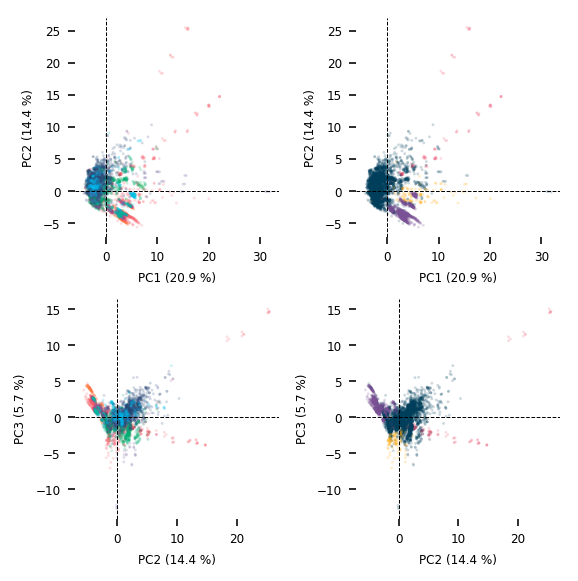

In [153]:
# plot the PCA projections
fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# color by src_tag 
src_to_c = {
    'moll0218': '#003f5c', 
    'pagl0314': '#1ea103', 
    'hine0817': '#2f4b7c', 
    'zhou1016': '#00ab4b', 
    'stow0817': '#665191', 
    'nich1118': '#00b37a', 
    'hine0217': '#a05195', 
    'groe0815': '#00b9a4',
    'zhen0917': '#d45087', 
    'righ0218': '#00bec8', 
    'may_0114': '#f95d6a', 
    'hine1217': '#00c1e4', 
    'zhou0817': '#ff7c43', 
    'bijl0517': '#00c2f6'
}
src = [_ for _ in src_to_c]
c = [src_to_c[_] for _ in c3sd.src_]
# PC1 vs. PC2
ax1.axvline(0, c='k', ls='--', lw=0.5)
ax1.axhline(0, c='k', ls='--', lw=0.5)
ax1.scatter(pc1, pc2, c=c, s=2, alpha=0.2, edgecolors='none')
for d in ['top', 'left', 'bottom', 'right']:
    ax1.spines[d].set_visible(False)
#ax1.set_title('color by src_tag', fontweight='bold')
ax1.set_xlabel('PC1 ({:.1f} %)'.format(pc1_evr * 100))
ax1.set_ylabel('PC2 ({:.1f} %)'.format(pc2_evr * 100))
#ax1.legend([mpatches.Patch(color=src_to_c[_]) for _ in src], src, frameon=False)
# PC2 vs. PC3
ax3.axvline(0, c='k', ls='--', lw=0.5)
ax3.axhline(0, c='k', ls='--', lw=0.5)
ax3.scatter(pc2, pc3, c=c, s=2, alpha=0.2, edgecolors='none')
for d in ['top', 'left', 'bottom', 'right']:
    ax3.spines[d].set_visible(False)
#ax1.set_title('color by src_tag')
ax3.set_xlabel('PC2 ({:.1f} %)'.format(pc2_evr * 100))
ax3.set_ylabel('PC3 ({:.1f} %)'.format(pc3_evr * 100))
#ax3.legend([mpatches.Patch(color=src_to_c[_]) for _ in src], src, frameon=False)
# color by chemical class label
lab_to_c = {
    'small molecule': '#003f5c',
    'lipid': '#7a5195',
    'carbohydrate': '#ef5675',
    'peptide': '#ffa600'
}
c = [lab_to_c[_] for _ in c3sd.cls_lab_]
lab = [_ for _ in lab_to_c]
# PC1 vs. PC2
ax2.axvline(0, c='k', ls='--', lw=0.5)
ax2.axhline(0, c='k', ls='--', lw=0.5)
ax2.scatter(pc1, pc2, c=c, s=2, alpha=0.2, edgecolors='none')
for d in ['top', 'left', 'bottom', 'right']:
    ax2.spines[d].set_visible(False)
#ax2.set_title('color by chem_class_label', fontweight='bold')
ax2.set_xlabel('PC1 ({:.1f} %)'.format(pc1_evr * 100))
ax2.set_ylabel('PC2 ({:.1f} %)'.format(pc2_evr * 100))
#ax2.legend([mpatches.Patch(color=lab_to_c[_]) for _ in lab], lab, frameon=False, loc='lower right')
# PC2 vs. PC3
ax4.axvline(0, c='k', ls='--', lw=0.5)
ax4.axhline(0, c='k', ls='--', lw=0.5)
ax4.scatter(pc2, pc3, c=c, s=2, alpha=0.2, edgecolors='none')
for d in ['top', 'left', 'bottom', 'right']:
    ax4.spines[d].set_visible(False)
#ax2.set_title('color by chem_class_label', fontweight='bold')
ax4.set_xlabel('PC2 ({:.1f} %)'.format(pc2_evr * 100))
ax4.set_ylabel('PC3 ({:.1f} %)'.format(pc3_evr * 100))
#ax4.legend([mpatches.Patch(color=lab_to_c[_]) for _ in lab], lab, frameon=False)

plt.tight_layout()
plt.savefig('PCA_projections.png', dpi=400, bbox_inches='tight')
plt.show()


First, examining the color by `src_tag` PCA projections we can see that while there is some group separation along PC1, there is not a strong contribution of inter-group differences to the overall variance in the dataset. Looking at the projections for PC2 and PC3 group separation is slightly more visible, but these components contribute less to the overall variance than PC1, again indicating that group differences do not contribute strongly to the overall variance. Examining the color by `chem_class_label` PCA projections we can see modest separation between the `small molecule` labeled compounds and all others occuring along PC1. This separation indicates that there is some contribution from the (rough) chemical class to the overall variance in the dataset, at least at the level of the `small molecule` class _vs._ all others. The `lipid`, `carbohydrate`, and `peptide` classes start to separate from one another in the projections for PC2 and PC3, indicating some inter-group variance is present among these classes but this variance is less significant than that present between them and the `small molecule` class. 

We can take a look at the loadings (stored in the `pca.components_` instance variable) to see which of the MDs contribute most strongly to the overall variance in the database along each of the principal axes. 

In [53]:
# loadings for each PC
pc1_load, pc2_load, pc3_load = pca.components_

# indices of top 3 MDs for PC1
pc1_md1, pc1_md2, pc1_md3 = np.abs(pc1_load).argsort()[::-1][:3]
# top 3 MDs for PC2
pc2_md1, pc2_md2, pc2_md3 = np.abs(pc2_load).argsort()[::-1][:3]
# top 3 MDs for PC3
pc3_md1, pc3_md2, pc3_md3 = np.abs(pc3_load).argsort()[::-1][:3]


# convert the indices into the actual MD identifiers
md_id = [
    'm/z',
    '[M+H]+', '[M+K]+', '[M+NH4]+', '[M+Na-2H]-', '[M+Na]+', '[M-H]-', 'other', 
    'c', 'f', 'cl', 'br',
    'i', 's', 'p', 'an',
    'cn', 'ao', 'co', 'hac',
    'hbam', 'hba', 'hbdm',
    'hbd', 'neg', 'pos',
    'asb', 'adb', 'atb', 'csb',
    'cdb', 'ctb', 'rbc',
    'asv', 'adv', 'atv', 'aqv',
    'cdv', 'ctv', 'cqv', 'r3',
    'r4', 'r5', 'r6', 'r7',
    'r8', 'r9', 'rg10', 'afr',
    'bfr'
]

# report top MDs 
print('PC1 top 3 MDs: {} ({}), {} ({}), {} ({})'.format(md_id[pc1_md1], pc1_md1,
                                                        md_id[pc1_md2], pc1_md2,
                                                        md_id[pc1_md3], pc1_md3))
print('PC2 top 3 MDs: {} ({}), {} ({}), {} ({})'.format(md_id[pc2_md1], pc2_md1, 
                                                        md_id[pc2_md2], pc2_md2, 
                                                        md_id[pc2_md3], pc2_md3))
print('PC3 top 3 MDs: {} ({}), {} ({}), {} ({})'.format(md_id[pc3_md1], pc3_md1,
                                                        md_id[pc3_md2], pc3_md2,
                                                        md_id[pc3_md3], pc3_md3,))

# top 10 PC1 loadings
print(np.abs(pc1_load).argsort()[::-1][:10])
print([md_id[_] for _ in np.abs(pc1_load).argsort()[::-1][:10]])

PC1 top 3 MDs: hac (19), m/z (0), ao (17)
PC2 top 3 MDs: hbd (23), ctv (38), r6 (43)
PC3 top 3 MDs: csb (29), afr (48), bfr (49)
[19  0 17 27 33 28 20  8 26 30]
['hac', 'm/z', 'ao', 'adb', 'asv', 'atb', 'hbam', 'c', 'asb', 'cdb']


Most important among these MDs are those that contribute strongly to separation along PC1, since that axis explains the most variance in the dataset as a whole. The top 3 MDs contributing to separation along PC1 are `hac` (heavy atom count), `m/z` (mass-to-charge ratio), and `ao` (acyclic oxygen count).  

We can also gererate plots of each MD vs. the PC1 scores, in order to get a more comprehensive and detailed view of their relative importances. 

In [154]:
def single_feature_PC_corr(feature, feat_lab, pc, pc_n, pc_evr, fig_name):
    """ generates a plot of the correlation between a specified feature and projections onto a specified 
        principle component """
    fig = plt.figure(figsize=(1.5, 1.33))
    ax = fig.add_subplot(111)

    # linear fit
    m, b, r_value, *_ = linregress(feature, pc)

    ax.scatter(feature, pc, c='#6666FF', s=1, alpha=0.25, edgecolors='none')
    ax.plot([min(feature), max(feature)], [m * min(feature) + b, m * max(feature) + b], 
            '-', c='#0000BB', lw=0.75, label=r'R$^2$ = {:.4f}'.format(r_value**2.))
    ax.set_xlabel(feat_lab)
    ax.set_ylabel('PC{} ({:.1f} %)'.format(pc_n, pc_evr * 100))
    ax.legend(frameon=False)
    
    for d in ['top', 'right']:
        ax.spines[d].set_visible(False)
    
    plt.savefig(fig_name, dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()

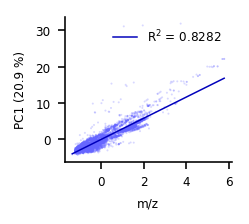

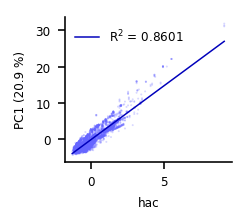

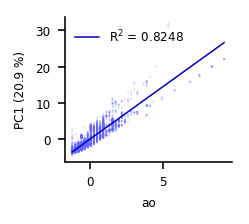

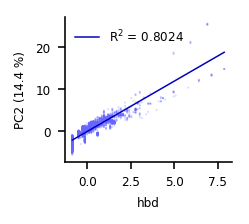

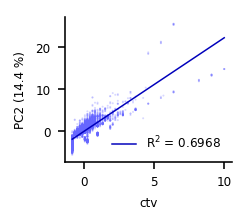

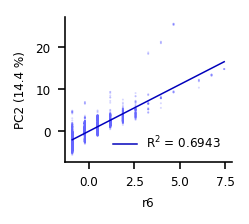

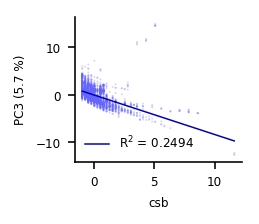

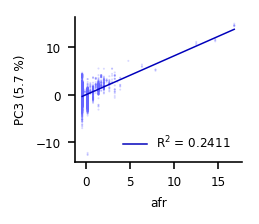

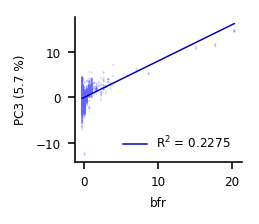

In [155]:
# m/z vs. PC1
single_feature_PC_corr([_[0] for _ in X_scaled], 'm/z', pc1, 1, pc1_evr, 'mz_v_pc1.png')
single_feature_PC_corr([_[19] for _ in X_scaled], 'hac', pc1, 1, pc1_evr, 'hac_v_pc1.png')
single_feature_PC_corr([_[17] for _ in X_scaled], 'ao', pc1, 1, pc1_evr, 'ao_v_pc1.png')
single_feature_PC_corr([_[23] for _ in X_scaled], 'hbd', pc2, 2, pc2_evr, 'hbd_v_pc2.png')
single_feature_PC_corr([_[38] for _ in X_scaled], 'ctv', pc2, 2, pc2_evr, 'ctv_v_pc2.png')
single_feature_PC_corr([_[43] for _ in X_scaled], 'r6', pc2, 2, pc2_evr, 'r6_v_pc2.png')
single_feature_PC_corr([_[29] for _ in X_scaled], 'csb', pc3, 3, pc3_evr, 'csb_v_pc3.png')
single_feature_PC_corr([_[48] for _ in X_scaled], 'afr', pc3, 3, pc3_evr, 'afr_v_pc3.png')
single_feature_PC_corr([_[49] for _ in X_scaled], 'bfr', pc3, 3, pc3_evr, 'bfr_v_pc3.png')

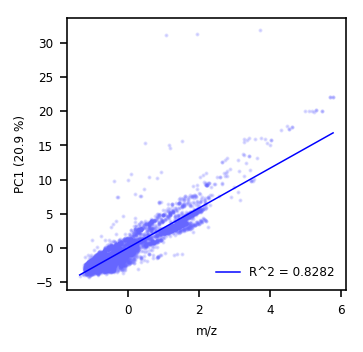

In [56]:
# m/z vs. PC1
fig = plt.figure(figsize=(2.5, 2.5))
ax = fig.add_subplot(111)

# linear fit
x_tmp = [_[0] for _ in X_scaled]
m, b, r_value, *_ = linregress(x_tmp, pc1)

ax.scatter(x_tmp, pc1, c='#6666FF', s=1, alpha=0.2)
ax.plot([min(x_tmp), max(x_tmp)], [m * min(x_tmp) + b, m * max(x_tmp) + b], 
        'b-', lw=0.75, label='R^2 = {:.4f}'.format(r_value**2.))
ax.set_xlabel(md_id[0])
ax.set_ylabel('PC1 ({:.1f} %)'.format(pc1_evr * 100))
ax.legend(frameon=False)

plt.show()


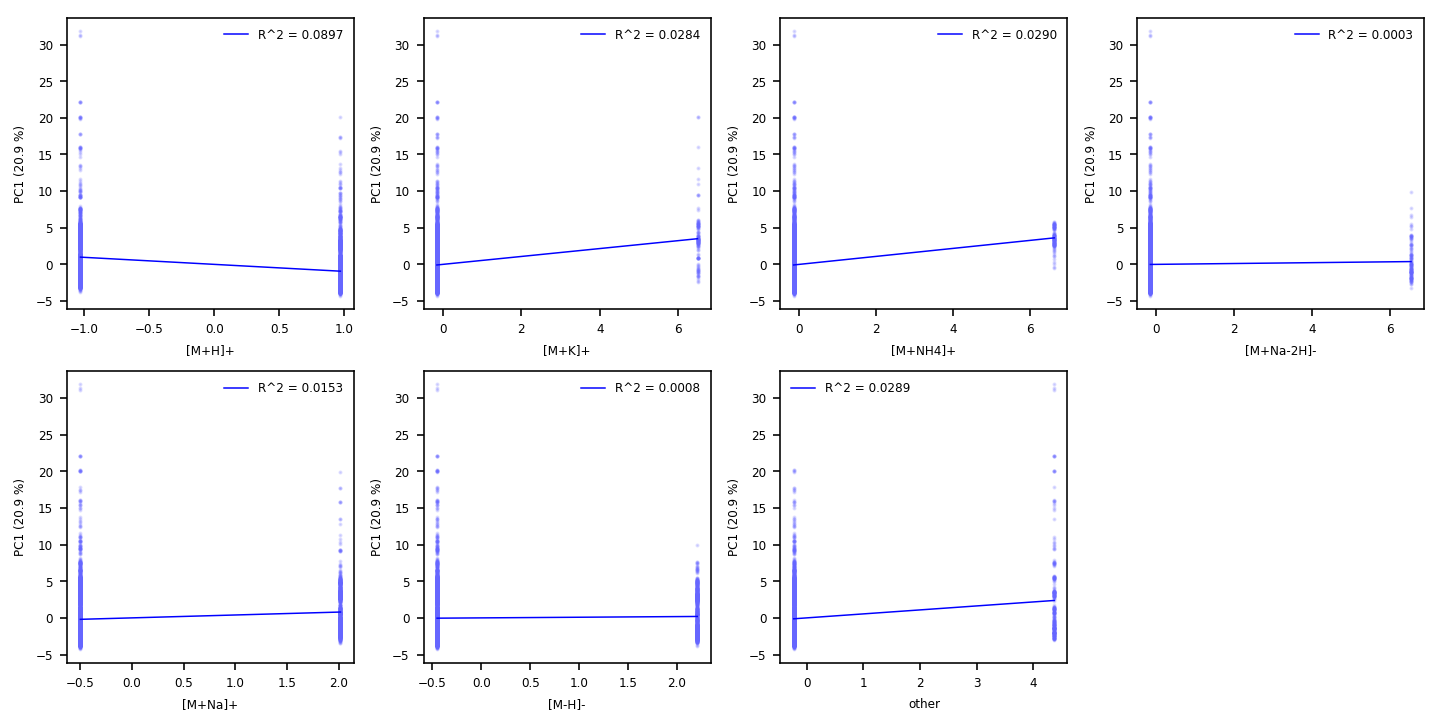

In [57]:
# encoded adducts vs. PC1
fig = plt.figure(figsize=(10, 5))

for i in range(2):
    for j in range(4):
        if i == 0 or (i == 1 and j < 3):
        
            idx = j + 4 * i + 1
        
            # linear fit
            x_tmp = [_[idx] for _ in X_scaled]
            m, b, r_value, *_ = linregress(x_tmp, pc1)
            
            ax = plt.subplot2grid((2, 4), (i, j))
            ax.scatter(x_tmp, pc1, c='#6666FF', s=1, alpha=0.2)
            ax.plot([min(x_tmp), max(x_tmp)], [m * min(x_tmp) + b, m * max(x_tmp) + b], 
                    'b-', lw=0.75, label='R^2 = {:.4f}'.format(r_value**2.))
            ax.set_xlabel(md_id[idx])
            ax.set_ylabel('PC1 ({:.1f} %)'.format(pc1_evr * 100))
            ax.legend(frameon=False)

plt.tight_layout()
plt.show()


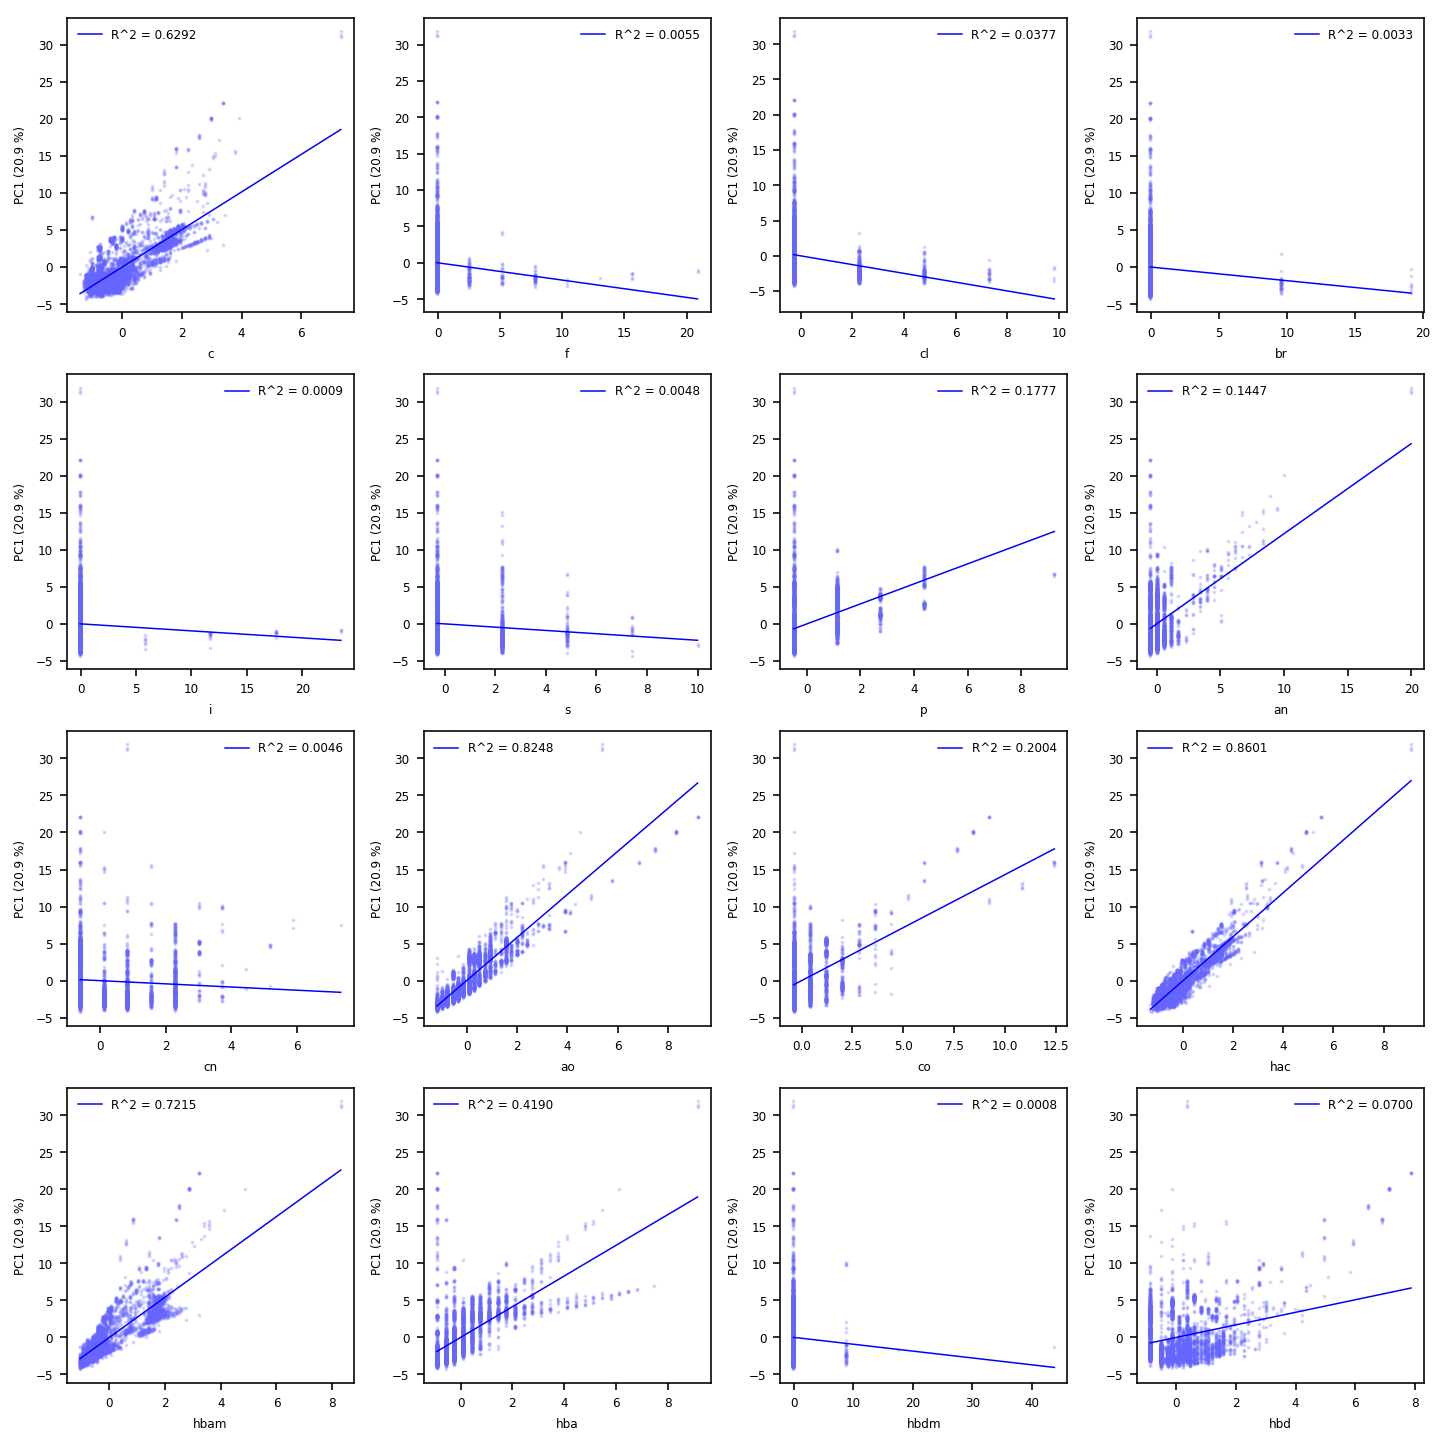

In [58]:
# the first 16 MQNs vs. PC1
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    for j in range(4):        
        idx = j + 4 * i + 8
        
        # linear fit
        x_tmp = [_[idx] for _ in X_scaled]
        m, b, r_value, *_ = linregress(x_tmp, pc1)

        ax = plt.subplot2grid((4, 4), (i, j))
        ax.scatter(x_tmp, pc1, c='#6666FF', s=1, alpha=0.2)
        ax.plot([min(x_tmp), max(x_tmp)], [m * min(x_tmp) + b, m * max(x_tmp) + b], 
                'b-', lw=0.75, label='R^2 = {:.4f}'.format(r_value**2.))
        ax.set_xlabel(md_id[idx])
        ax.set_ylabel('PC1 ({:.1f} %)'.format(pc1_evr * 100))
        ax.legend(frameon=False)

plt.tight_layout()
plt.show()


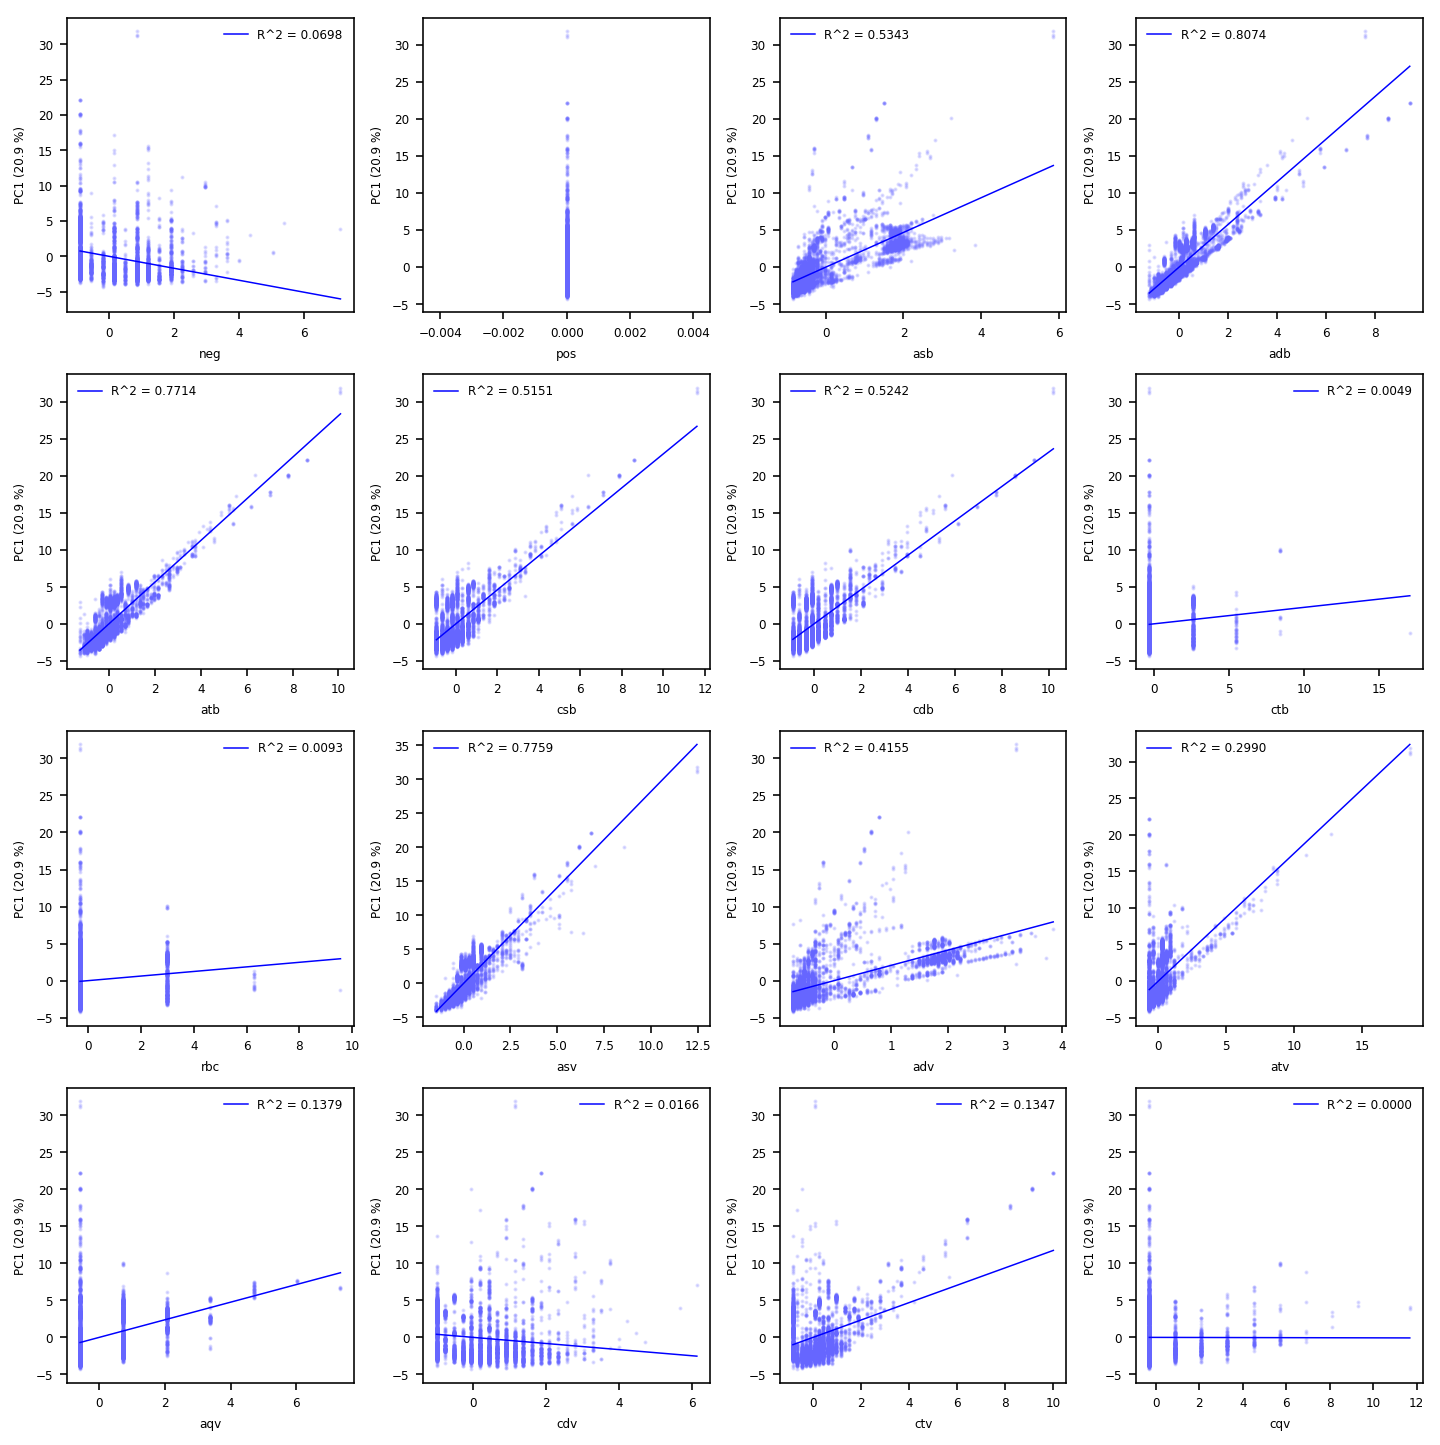

In [59]:
# the next 16 MQNs vs. PC1
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    for j in range(4): 
        idx = j + 4 * i + 24
        
        # pos has only one x value, do not try to perform linear fit
        do_fit = True
        if idx == 25:
            do_fit = False
        
        # linear fit
        x_tmp = [_[idx] for _ in X_scaled]
        if do_fit:
            m, b, r_value, *_ = linregress(x_tmp, pc1)

        ax = plt.subplot2grid((4, 4), (i, j))
        ax.scatter(x_tmp, pc1, c='#6666FF', s=1, alpha=0.2)
        if do_fit:
            ax.plot([min(x_tmp), max(x_tmp)], [m * min(x_tmp) + b, m * max(x_tmp) + b], 
                    'b-', lw=0.75, label='R^2 = {:.4f}'.format(r_value**2.))
            ax.legend(frameon=False)
        ax.set_xlabel(md_id[idx])
        ax.set_ylabel('PC1 ({:.1f} %)'.format(pc1_evr * 100))
        
plt.tight_layout()
plt.show()


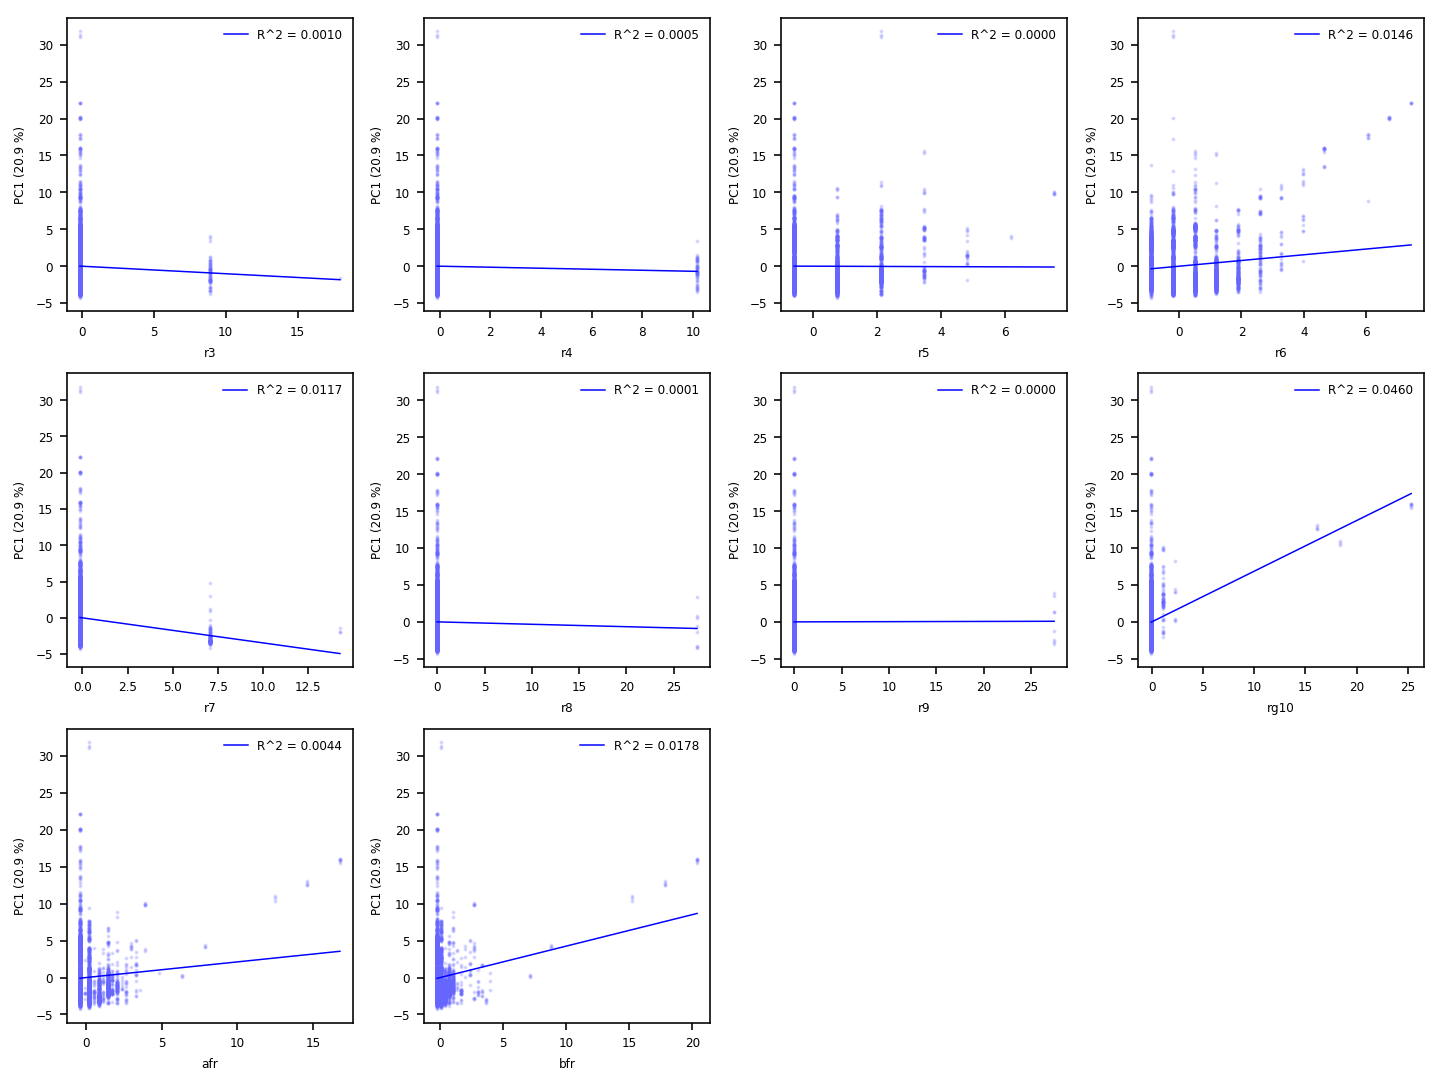

In [60]:
# the remaining MQNs vs. PC1
fig = plt.figure(figsize=(10, 7.5))

for i in range(4):
    for j in range(4): 
        if i < 2 or (i == 2 and j < 2):
            idx = j + 4 * i + 40
            
            # linear fit
            x_tmp = [_[idx] for _ in X_scaled]
            m, b, r_value, *_ = linregress(x_tmp, pc1)
            
            ax = plt.subplot2grid((3, 4), (i, j))
            ax.scatter(x_tmp, pc1, c='#6666FF', s=1, alpha=0.2)
            ax.plot([min(x_tmp), max(x_tmp)], [m * min(x_tmp) + b, m * max(x_tmp) + b], 
                    'b-', lw=0.75, label='R^2 = {:.4f}'.format(r_value**2.))
            ax.set_xlabel(md_id[idx])
            ax.set_ylabel('PC1 ({:.1f} %)'.format(pc1_evr * 100))
            ax.legend(frameon=False)

plt.tight_layout()
plt.show()


### PLS Regression Analysis on all Molecular Descriptors with CCS
First, compute a PLS Regression analysis ([PLS1](https://en.wikipedia.org/wiki/Partial_least_squares_regression#PLS1), specifically) using all 42 MQNs, in addition to the m/z and encoded MS adduct and including all datasets and using CCS as the target variable. Then, plot the contribution to to separation in target variable (_i.e._ `scores[0]`) vs. variance orthogonal to `scores[0]` (_i.e._ `scores[1]`) and color by `src_tag` and `chem_class_label` attributes to see how the dataset as a whole can be differentiated by either attribute with respect to distributions of CCS values. 

In [61]:
plsr = PLSRegression(n_components=2, scale=False)
plsr.fit(X_scaled, c3sd.y_)


PLSRegression(copy=True, max_iter=500, n_components=2, scale=False, tol=1e-06)

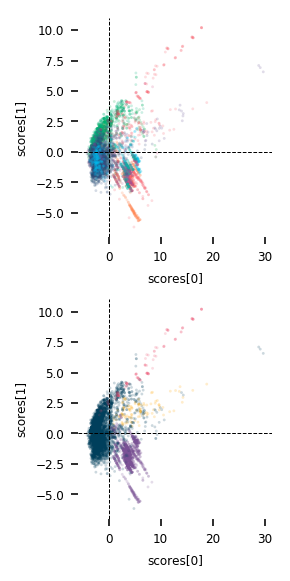

In [156]:
# plot the PLS Regression projections
fig = plt.figure(figsize=(2, 4))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# color by src_tag 
c = [src_to_c[_] for _ in c3sd.src_]
# PC1 vs. PC2
ax1.axvline(0, c='k', ls='--', lw=0.5)
ax1.axhline(0, c='k', ls='--', lw=0.5)
ax1.scatter(*plsr.x_scores_.T, c=c, s=2, alpha=0.2, edgecolors='none')
for d in ['top', 'left', 'bottom', 'right']:
    ax1.spines[d].set_visible(False)
#ax1.set_title('color by src_tag', fontweight='bold')
ax1.set_xlabel('scores[0]')
ax1.set_ylabel('scores[1]')
#ax1.legend([mpatches.Patch(color=src_to_c[_]) for _ in src], src, frameon=False)

# color by chemical class label
c = [lab_to_c[_] for _ in c3sd.cls_lab_]
# PC1 vs. PC2
ax2.axvline(0, c='k', ls='--', lw=0.5)
ax2.axhline(0, c='k', ls='--', lw=0.5)
ax2.scatter(*plsr.x_scores_.T, c=c, s=2, alpha=0.2, edgecolors='none')
for d in ['top', 'left', 'bottom', 'right']:
    ax2.spines[d].set_visible(False)
#ax2.set_title('color by chem_class_label', fontweight='bold')
ax2.set_xlabel('scores[0]')
ax2.set_ylabel('scores[1]')
#ax2.legend([mpatches.Patch(color=lab_to_c[_]) for _ in lab], lab, frameon=False, loc='lower right')

plt.tight_layout()
plt.savefig('PLS-RA_projections.png', dpi=400, bbox_inches='tight')
plt.show()


The `scores[0]` axis in the above projections from PLS Regression analysis corresponds to the multidimensional axis in `X` which explains the most variance in the target variable (CCS). The `scores[1]` axis corresponds to the multidimensional axis in `X` that is orthogonal to the `scores[0]` axis and explains the most possible variance in `X`. Considering first the color by `src_tag` plot, there does not appear to be a great deal of separation in the `scores[0]` axis between the different groups. In other words, variance in CCS for the collection as a whole does not  appear to be strongly influenced by variance between individual datasets used to build the collection. Looking at the color by `chem_class_label` plot, we see that there does appear to be some separation between the `small molecule` labeled compounds and all other labels along the `scores[0]` axis. This indicates that there is some variation in the distribution of CCS values in the collection as a whole that can be explained somewhat by the (rough) chemical label, at least between `small molecule` and all other labels. Taken as a whole, these results seem to be consistent with those from the PCA (specifically group separation along PC1), which suggests that the axis in `X` that explains the most variance in the dataset as a whole (PC1) has some amount of correlation with the axis in `X` that explains the most variance in CCS (`scores[0]`). We can test this by simply plotting PC1 against `scores[0]` for the full dataset and see how strongly they are correlated.

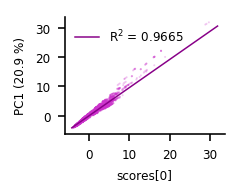

In [157]:
fig = plt.figure(figsize=(1.67, 1.33))
ax = fig.add_subplot(111)

m, b, r_value, *_ = linregress(pc1, plsr.x_scores_.T[0])

ax.scatter(plsr.x_scores_.T[0], pc1, s=1, alpha=0.25, c='#CC33CC', edgecolors='none')
ax.plot([min(pc1), max(pc1)], [m * min(pc1) + b, m * max(pc1) + b], 
        ls='-', c='#880088', lw=0.75, label=r'R$^2$ = {:.4f}'.format(r_value**2.))
ax.set_ylabel('PC1 ({:.1f} %)'.format(pc1_evr * 100))
ax.set_xlabel('scores[0]')
ax.legend(frameon=False)

for d in ['top', 'right']:
    ax.spines[d].set_visible(False)

plt.tight_layout()
plt.savefig('scores0_v_pc1.png', dpi=300, bbox_inches='tight')
plt.show()


In [177]:
def single_feature_PLSR_corr(feature, feat_lab, fig_name):
    """ generates a plot of the correlation between a specified feature and projections onto a
        the scores[0] axis from PLSR and CCS"""
    fig = plt.figure(figsize=(1.67, 1.33))
    ax = fig.add_subplot(111)
    axt = ax.twinx()

    # linear fit (against scores[0])
    m, b, r_value, *_ = linregress(feature, plsr.x_scores_.T[0])

    ax.scatter(feature, plsr.x_scores_.T[0], c='#6666FF', s=0.5, alpha=0.5, marker='.', edgecolors='none')
    ax.plot([min(feature), max(feature)], [m * min(feature) + b, m * max(feature) + b], 
            '-', c='#0000BB', lw=0.75)
    ax.set_xlabel(feat_lab)
    ax.set_ylabel('scores[0]', color='b')
    
    m2, b2, r_value2, *_ = linregress(feature, c3sd.y_)
    axt.scatter(feature, c3sd.y_, c='#FF6666', s=0.5, alpha=0.5, marker='.', edgecolors='none')
    axt.plot([min(feature), max(feature)], [m2 * min(feature) + b2, m2 * max(feature) + b2], 'r-', lw=0.75)
    axt.set_ylabel(r'CCS (Å$^2$)', color='r')
    lgnd = axt.legend([mlines.Line2D([], [], color='b', lw=0.5),
                      mlines.Line2D([], [], color='r', lw=0.5)], 
                     [r'R$^2$={:.4f}'.format(r_value**2.), r'R$^2$={:.4f}'.format(r_value2**2.)], 
                      fontsize=5, framealpha=1, labelspacing=0.2)
    
    lcolor = ['b', 'r']
    for t, c in zip(lgnd.get_texts(), lcolor):
        t.set_color(c)

    
    for d in ['top', 'right']:
        ax.spines[d].set_visible(False)
        
    for d in ['top', 'left']:
        axt.spines[d].set_visible(False)
        
    ax.spines['left'].set_color('b')
    axt.spines['right'].set_color('r')
    ax.tick_params(axis='y', colors='b')
    axt.tick_params(axis='y', colors='r')
    
    plt.tight_layout()
    plt.savefig(fig_name, dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()

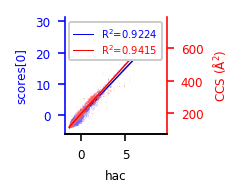

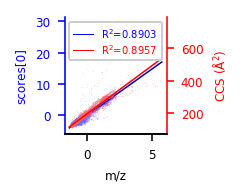

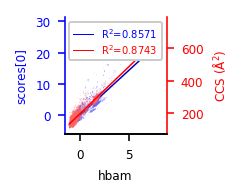

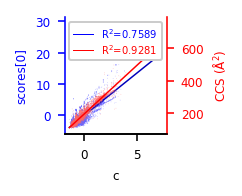

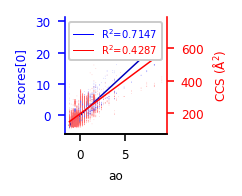

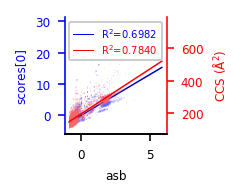

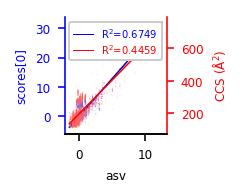

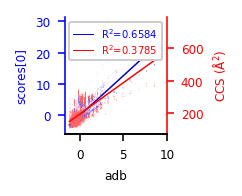

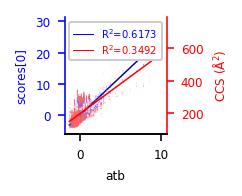

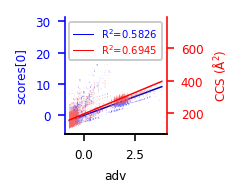

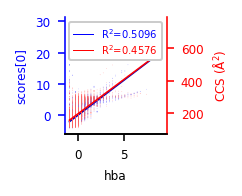

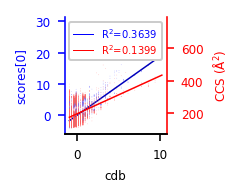

In [178]:
single_feature_PLSR_corr([_[19] for _ in X_scaled], 'hac', 'hac_v_scores0.png')
single_feature_PLSR_corr([_[0] for _ in X_scaled], 'm/z', 'mz_v_scores0.png')
single_feature_PLSR_corr([_[20] for _ in X_scaled], 'hbam', 'hbam_v_scores0.png')
single_feature_PLSR_corr([_[8] for _ in X_scaled], 'c', 'c_v_scores0.png')
single_feature_PLSR_corr([_[17] for _ in X_scaled], 'ao', 'ao_v_scores0.png')
single_feature_PLSR_corr([_[26] for _ in X_scaled], 'asb', 'asb_v_scores0.png')
single_feature_PLSR_corr([_[33] for _ in X_scaled], 'asv', 'asv_v_scores0.png')
single_feature_PLSR_corr([_[27] for _ in X_scaled], 'adb', 'adb_v_scores0.png')
single_feature_PLSR_corr([_[28] for _ in X_scaled], 'atb', 'atb_v_scores0.png')
single_feature_PLSR_corr([_[34] for _ in X_scaled], 'adv', 'adv_v_scores0.png')
single_feature_PLSR_corr([_[21] for _ in X_scaled], 'hba', 'hba_v_scores0.png')
single_feature_PLSR_corr([_[30] for _ in X_scaled], 'cdb', 'cdb_v_scores0.png')

Indeed, PC1 and `scores[0]` appear to be strongly correlated indicating that many of the strong contributors to the variance of the dataset as a whole also contribute to variance in CCS.

We can look at the loadings from the PLS Regression (stored in the `plsr.x_loadings_` instance variable) to see which MDs contribute most to the variance in the target variable (CCS). First, we will look at all of the MDs, sorted by the magnitude of their loadings in descending order to get an idea of their rank-order of importance. Next we will generate plots of each MD _vs._ `scores[0]` and CCS to make a visual assessment of which MDs carry the most predictive power.

In [158]:
[(_, md_id[_]) for _ in np.abs(plsr.x_loadings_.T[0]).argsort()[::-1]]

[(19, 'hac'),
 (0, 'm/z'),
 (20, 'hbam'),
 (8, 'c'),
 (17, 'ao'),
 (26, 'asb'),
 (33, 'asv'),
 (27, 'adb'),
 (28, 'atb'),
 (34, 'adv'),
 (21, 'hba'),
 (30, 'cdb'),
 (29, 'csb'),
 (35, 'atv'),
 (14, 'p'),
 (36, 'aqv'),
 (15, 'an'),
 (18, 'co'),
 (24, 'neg'),
 (1, '[M+H]+'),
 (38, 'ctv'),
 (3, '[M+NH4]+'),
 (37, 'cdv'),
 (10, 'cl'),
 (2, '[M+K]+'),
 (47, 'rg10'),
 (7, 'other'),
 (23, 'hbd'),
 (32, 'rbc'),
 (16, 'cn'),
 (5, '[M+Na]+'),
 (31, 'ctb'),
 (44, 'r7'),
 (13, 's'),
 (49, 'bfr'),
 (42, 'r5'),
 (9, 'f'),
 (11, 'br'),
 (40, 'r3'),
 (43, 'r6'),
 (12, 'i'),
 (22, 'hbdm'),
 (6, '[M-H]-'),
 (41, 'r4'),
 (39, 'cqv'),
 (4, '[M+Na-2H]-'),
 (45, 'r8'),
 (48, 'afr'),
 (46, 'r9'),
 (25, 'pos')]

Next, we can plot each MD against `scores[0]` from PLS Regression analysis and CCS to visually inspect which features are most important. 

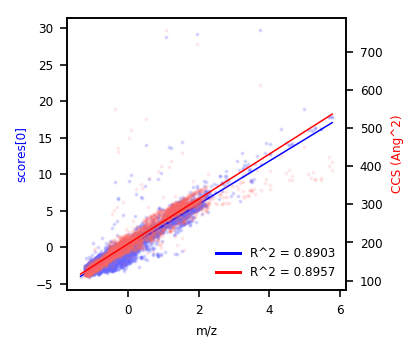

In [65]:
# m/z vs. scores[0] and CCS
fig = plt.figure(figsize=(2.5, 2.5))
ax = fig.add_subplot(111)
axt = ax.twinx()

x_tmp = [_[0] for _ in X_scaled]
m1, b1, r_value1, *_ = linregress(x_tmp, plsr.x_scores_.T[0])
ax.scatter(x_tmp, plsr.x_scores_.T[0], c='#6666FF', s=1, alpha=0.2)
ax.plot([min(x_tmp), max(x_tmp)], [m1 * min(x_tmp) + b1, m1 * max(x_tmp) + b1], 'b-', lw=0.75)
m2, b2, r_value2, *_ = linregress(x_tmp, c3sd.y_)
axt.scatter([_[0] for _ in X_scaled], c3sd.y_, c='#FF6666', s=1, alpha=0.1)
axt.plot([min(x_tmp), max(x_tmp)], [m2 * min(x_tmp) + b2, m2 * max(x_tmp) + b2], 'r-', lw=0.75)
ax.set_xlabel(md_id[0])
ax.set_ylabel('scores[0]', color='b')
axt.set_ylabel('CCS (Ang^2)', color='r')
ax.legend([mlines.Line2D([], [], color='b'), mlines.Line2D([], [], color='r')], 
          ['R^2 = {:.4f}'.format(r_value1**2.), 'R^2 = {:.4f}'.format(r_value2**2.)], 
          frameon=False)


plt.show()


We already know that `m/z` is highly correlated with CCS, so a high degree of correlation with `scores[0]` as well is what we expect to see from the PLS Regression analysis.

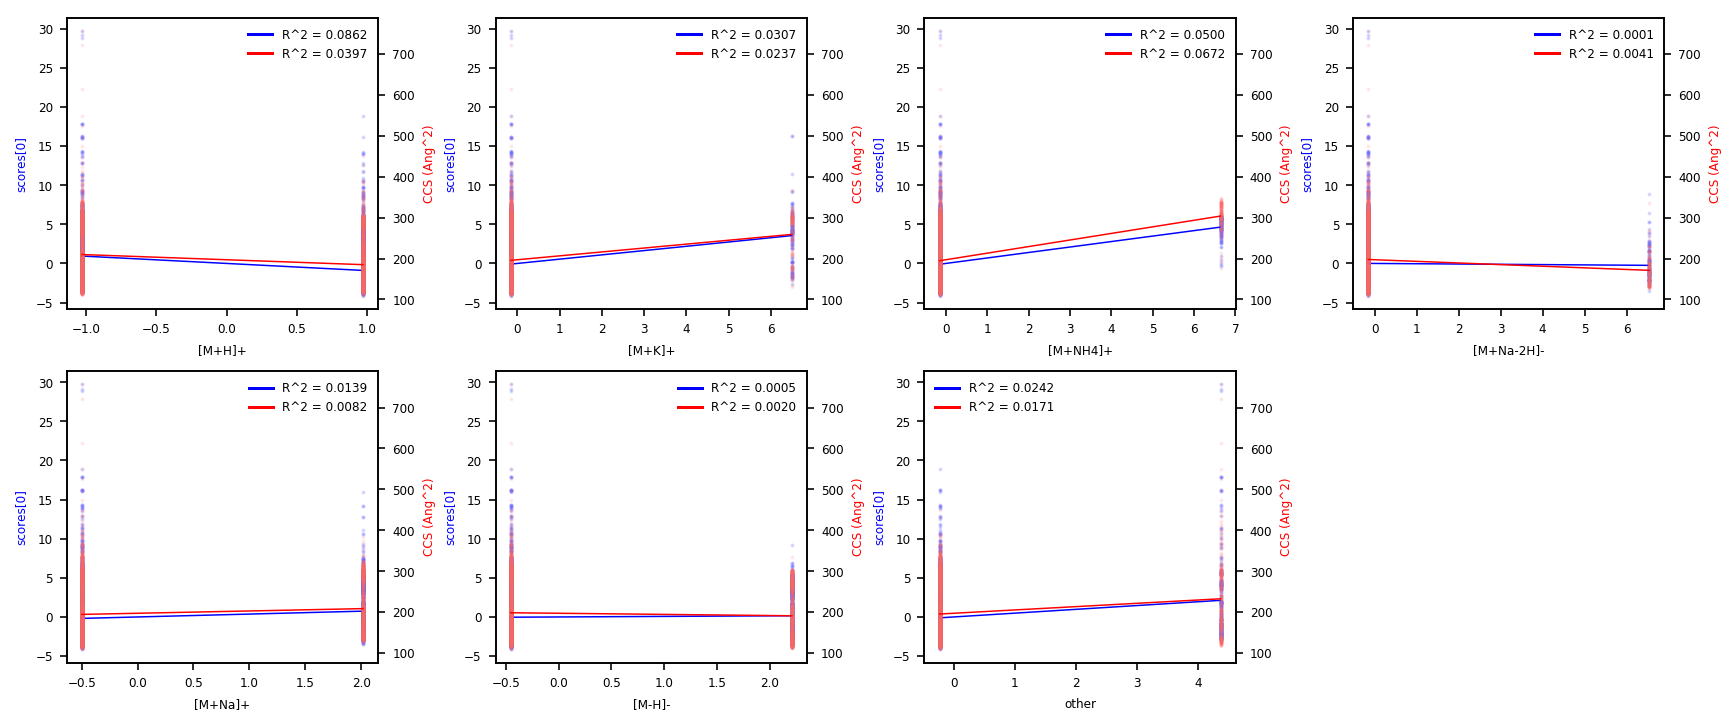

In [66]:
# encoded adducts vs. scores[0] and CCS
fig = plt.figure(figsize=(12, 5))

for i in range(2):
    for j in range(4):
        if i == 0 or (i == 1 and j < 3):
        
            idx = j + 4 * i + 1
            
            x_tmp = [_[idx] for _ in X_scaled]
            m1, b1, r_value1, *_ = linregress(x_tmp, plsr.x_scores_.T[0])
            ax = plt.subplot2grid((2, 4), (i, j))
            axt = ax.twinx()
            ax.scatter(x_tmp, plsr.x_scores_.T[0], c='#6666FF', s=1, alpha=0.2)
            ax.plot([min(x_tmp), max(x_tmp)], [m1 * min(x_tmp) + b1, m1 * max(x_tmp) + b1], 'b-', lw=0.75)
            m2, b2, r_value2, *_ = linregress(x_tmp, c3sd.y_)
            axt.scatter(x_tmp, c3sd.y_, c='#FF6666', s=1, alpha=0.1)
            axt.plot([min(x_tmp), max(x_tmp)], [m2 * min(x_tmp) + b2, m2 * max(x_tmp) + b2], 'r-', lw=0.75)
            ax.set_xlabel(md_id[idx])
            ax.set_ylabel('scores[0]', color='b')
            axt.set_ylabel('CCS (Ang^2)', color='r')
            ax.legend([mlines.Line2D([], [], color='b'), mlines.Line2D([], [], color='r')], 
                      ['R^2 = {:.4f}'.format(r_value1**2.), 'R^2 = {:.4f}'.format(r_value2**2.)], 
                      frameon=False)

plt.tight_layout()
plt.show()


It is hard to interpret the impact of individual encoded adducts when viewed in this fashion... Boxplots would be the preferred way of representing this data...

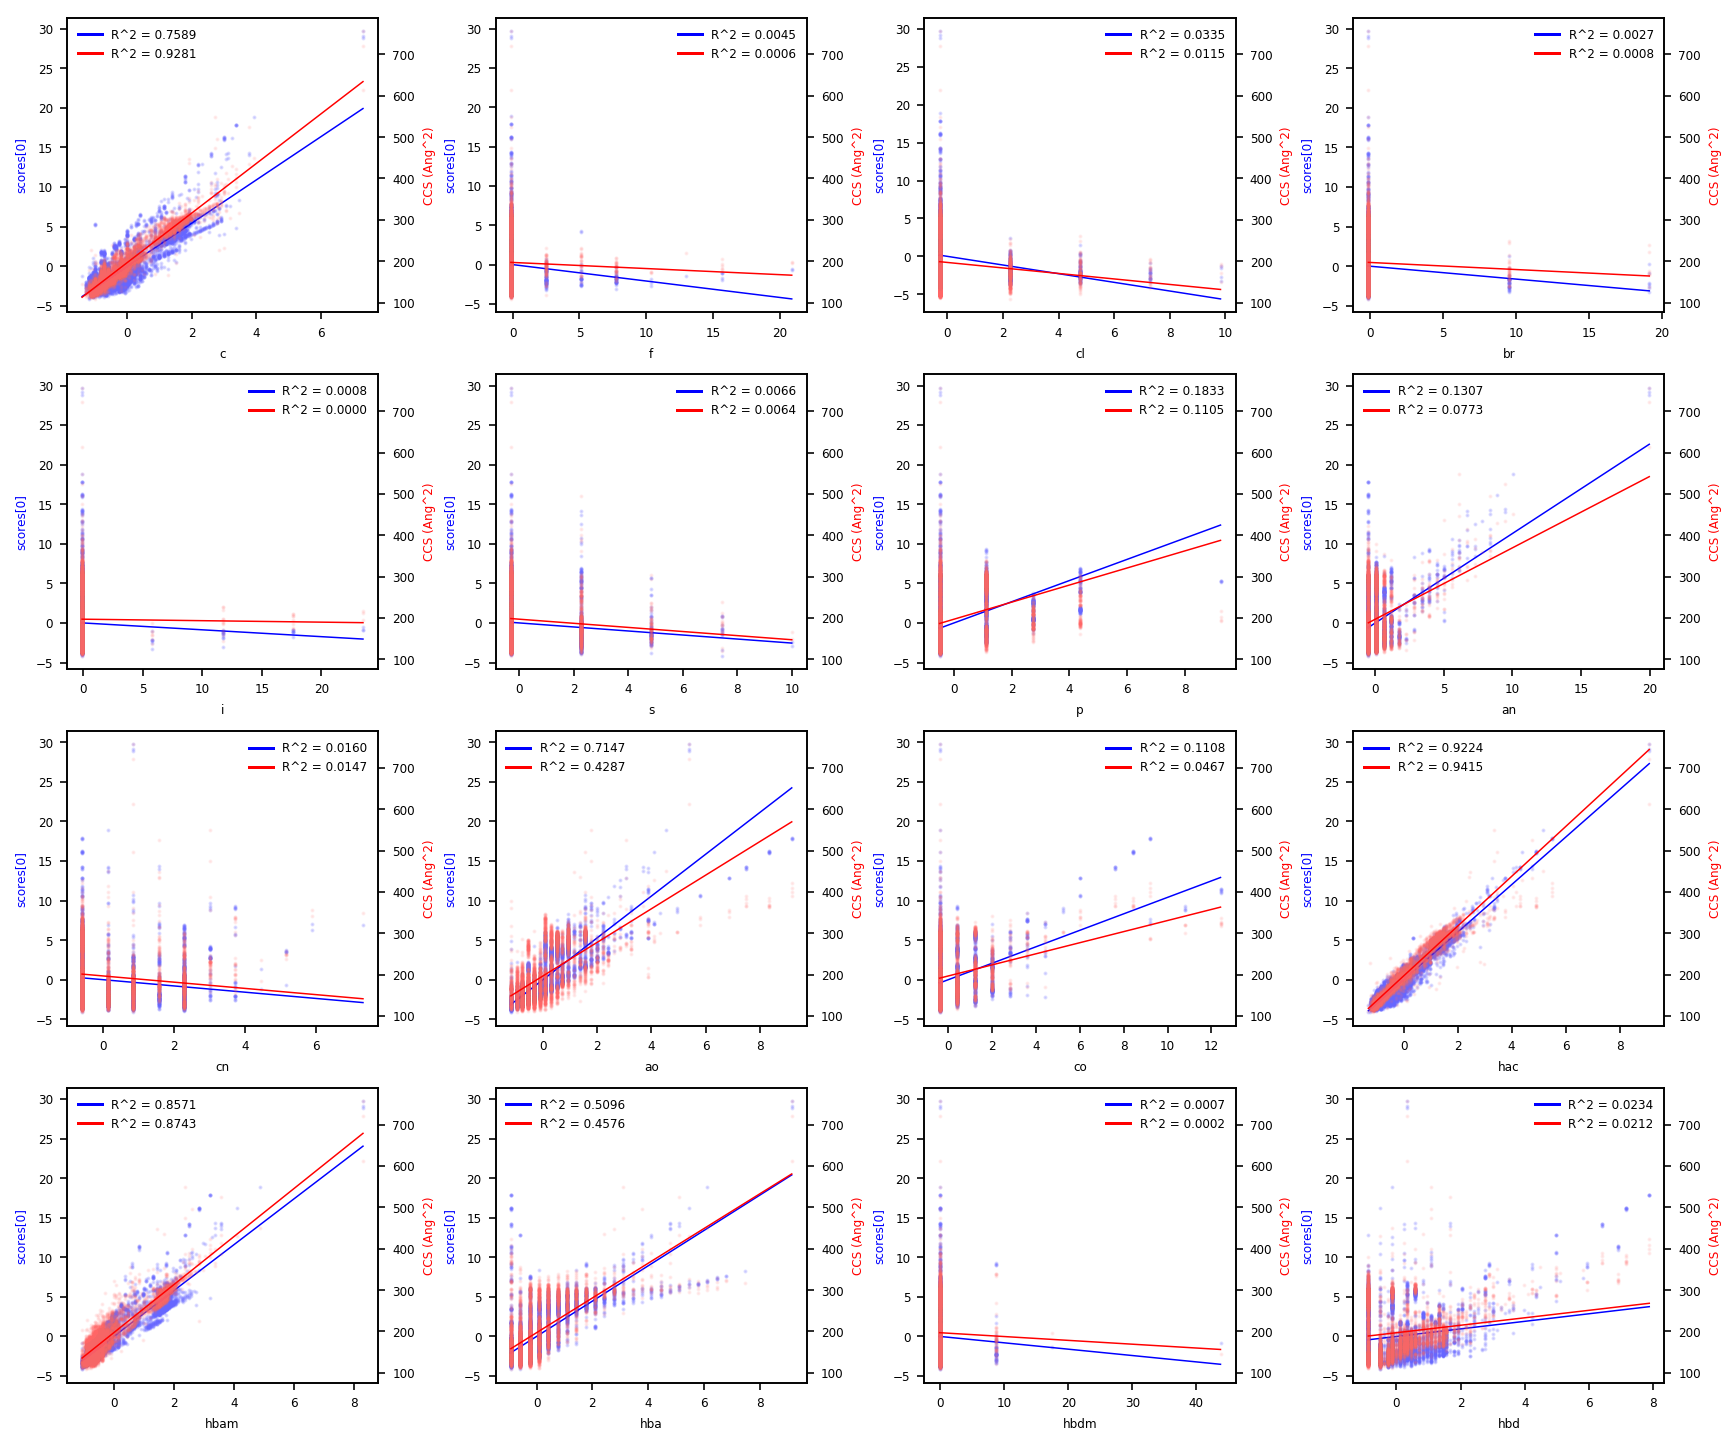

In [67]:
# the first 16 MQNs vs. scores[0] and CCS
fig = plt.figure(figsize=(12, 10))

for i in range(4):
    for j in range(4):        
        idx = j + 4 * i + 8
        
        x_tmp = [_[idx] for _ in X_scaled]
        m1, b1, r_value1, *_ = linregress(x_tmp, plsr.x_scores_.T[0])
        ax = plt.subplot2grid((4, 4), (i, j))
        axt = ax.twinx()
        ax.scatter(x_tmp, plsr.x_scores_.T[0], c='#6666FF', s=1, alpha=0.2)
        ax.plot([min(x_tmp), max(x_tmp)], [m1 * min(x_tmp) + b1, m1 * max(x_tmp) + b1], 'b-', lw=0.75)
        m2, b2, r_value2, *_ = linregress(x_tmp, c3sd.y_)
        axt.scatter(x_tmp, c3sd.y_, c='#FF6666', s=1, alpha=0.1)
        axt.plot([min(x_tmp), max(x_tmp)], [m2 * min(x_tmp) + b2, m2 * max(x_tmp) + b2], 'r-', lw=0.75)
        ax.set_xlabel(md_id[idx])
        ax.set_ylabel('scores[0]', color='b')
        axt.set_ylabel('CCS (Ang^2)', color='r')
        ax.legend([mlines.Line2D([], [], color='b'), mlines.Line2D([], [], color='r')], 
                  ['R^2 = {:.4f}'.format(r_value1**2.), 'R^2 = {:.4f}'.format(r_value2**2.)], 
                  frameon=False)

plt.tight_layout()
plt.show()


Examining the first 16 MQNs, the following show strong correlations with `scores[0]` and CCS:
* `c` - carbon count
* `hac` - heavy atom count
* `hbam` - H-bond acceptor sites
* `ao` - acyclic oxygen count
* `hba` - H-bond acceptor atoms

Since this group of MQNs consists of counts of various atoms or groups, it is possible that the correlation of less common atoms/groups may be obscured by variation among samples not containing the atom/group. This appears to be the case with `hbd` (H-bond donor atoms) where a high degree of variation among the samples in the far left (those without any H-bond donor atoms) effectively masks the clear visual correlation among the values to their right. It may be detrimental to exclude these features when triaining predictive models because they can add useful information for the compounds that have nonzero values.

Interpret the above results with respect to what attributes seem to have the most influence on CCS

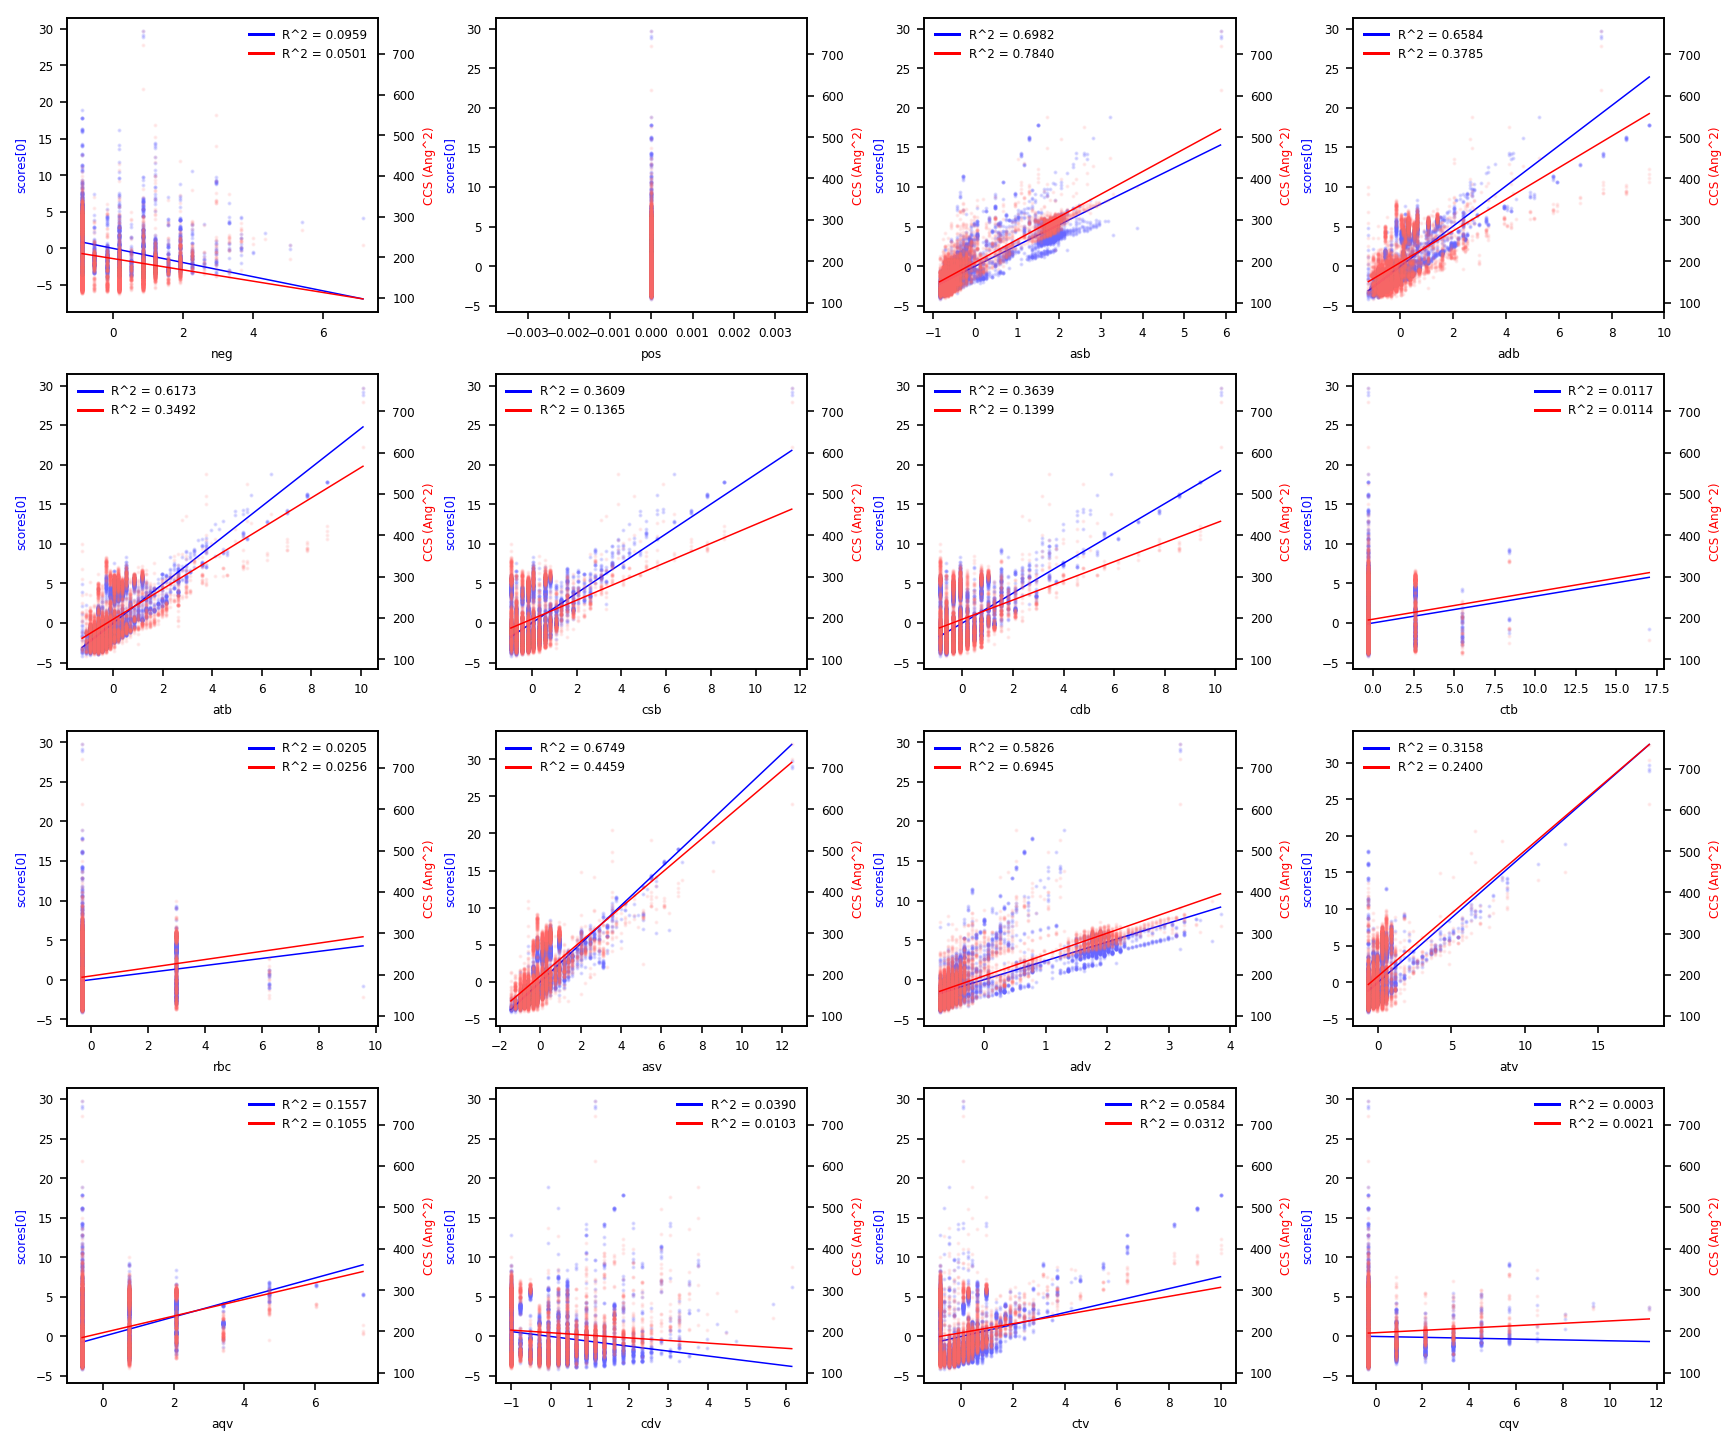

In [68]:
# the next 16 MQNs vs. scores[0] and CCS
fig = plt.figure(figsize=(12, 10))

for i in range(4):
    for j in range(4): 
        idx = j + 4 * i + 24
        
        # pos has only one x value, do not try to perform linear fit
        do_fit = True
        if idx == 25:
            do_fit = False
        
        x_tmp = [_[idx] for _ in X_scaled]
        
        ax = plt.subplot2grid((4, 4), (i, j))
        axt = ax.twinx()
        ax.scatter(x_tmp, plsr.x_scores_.T[0], c='#6666FF', s=1, alpha=0.2)
        if do_fit:
            m1, b1, r_value1, *_ = linregress(x_tmp, plsr.x_scores_.T[0])
            ax.plot([min(x_tmp), max(x_tmp)], [m1 * min(x_tmp) + b1, m1 * max(x_tmp) + b1], 'b-', lw=0.75)
            
        axt.scatter(x_tmp, c3sd.y_, c='#FF6666', s=1, alpha=0.1)
        if do_fit:
            m2, b2, r_value2, *_ = linregress(x_tmp, c3sd.y_)
            axt.plot([min(x_tmp), max(x_tmp)], [m2 * min(x_tmp) + b2, m2 * max(x_tmp) + b2], 'r-', lw=0.75)
        ax.set_xlabel(md_id[idx])
        ax.set_ylabel('scores[0]', color='b')
        axt.set_ylabel('CCS (Ang^2)', color='r')
        if do_fit:
            ax.legend([mlines.Line2D([], [], color='b'), mlines.Line2D([], [], color='r')], 
                      ['R^2 = {:.4f}'.format(r_value1**2.), 'R^2 = {:.4f}'.format(r_value2**2.)], 
                      frameon=False)

plt.tight_layout()
plt.show()


In the next group of MQNs, the following features are strongly correlated with `scores[0]` and CCS:
* `asb` - acyclic single bond count
* `adb` - acyclic double bond count
* `atb` - acyclic triple bond count
* `csb` - cyclic single bond count
* `cdb` - cyclic double bond count
* `asv` - acyclic single valent nodes
* `adv` - acyclic divalent nodes
* `atv` - acyclic trivalent nodes
* `ctv` - cyclic trivalent nodes

Both the total number of bonds and the distribution of bond orders in acyclic systems (captured by `asb`, `adb`, `atv`) have a strong relationship with CCS. The influence of bond number/order is less in cyclic systems (captured by `csb`, `cdb`), which would make sense considering the lesser effect that adding bonds is expected to have on the overall size of a cyclic system _vs._ an acyclic system (essentially, constraining side/segment length and considering the maximal extent of polygons _vs._ lines with the same number of segments, both increase linearly with number of sides but the polygons at <1/2 the rate: `-  =  |>  ==  |>=  === |>==  ====` _vs._ `-  --  ---  ----  -----  ------  -------  --------`). The degree of branching in a acyclic systems (captured by `asv`, `adv`, `atv`) also has a strong relationship with CCS, which directly relates to the overall compactness of the system. 

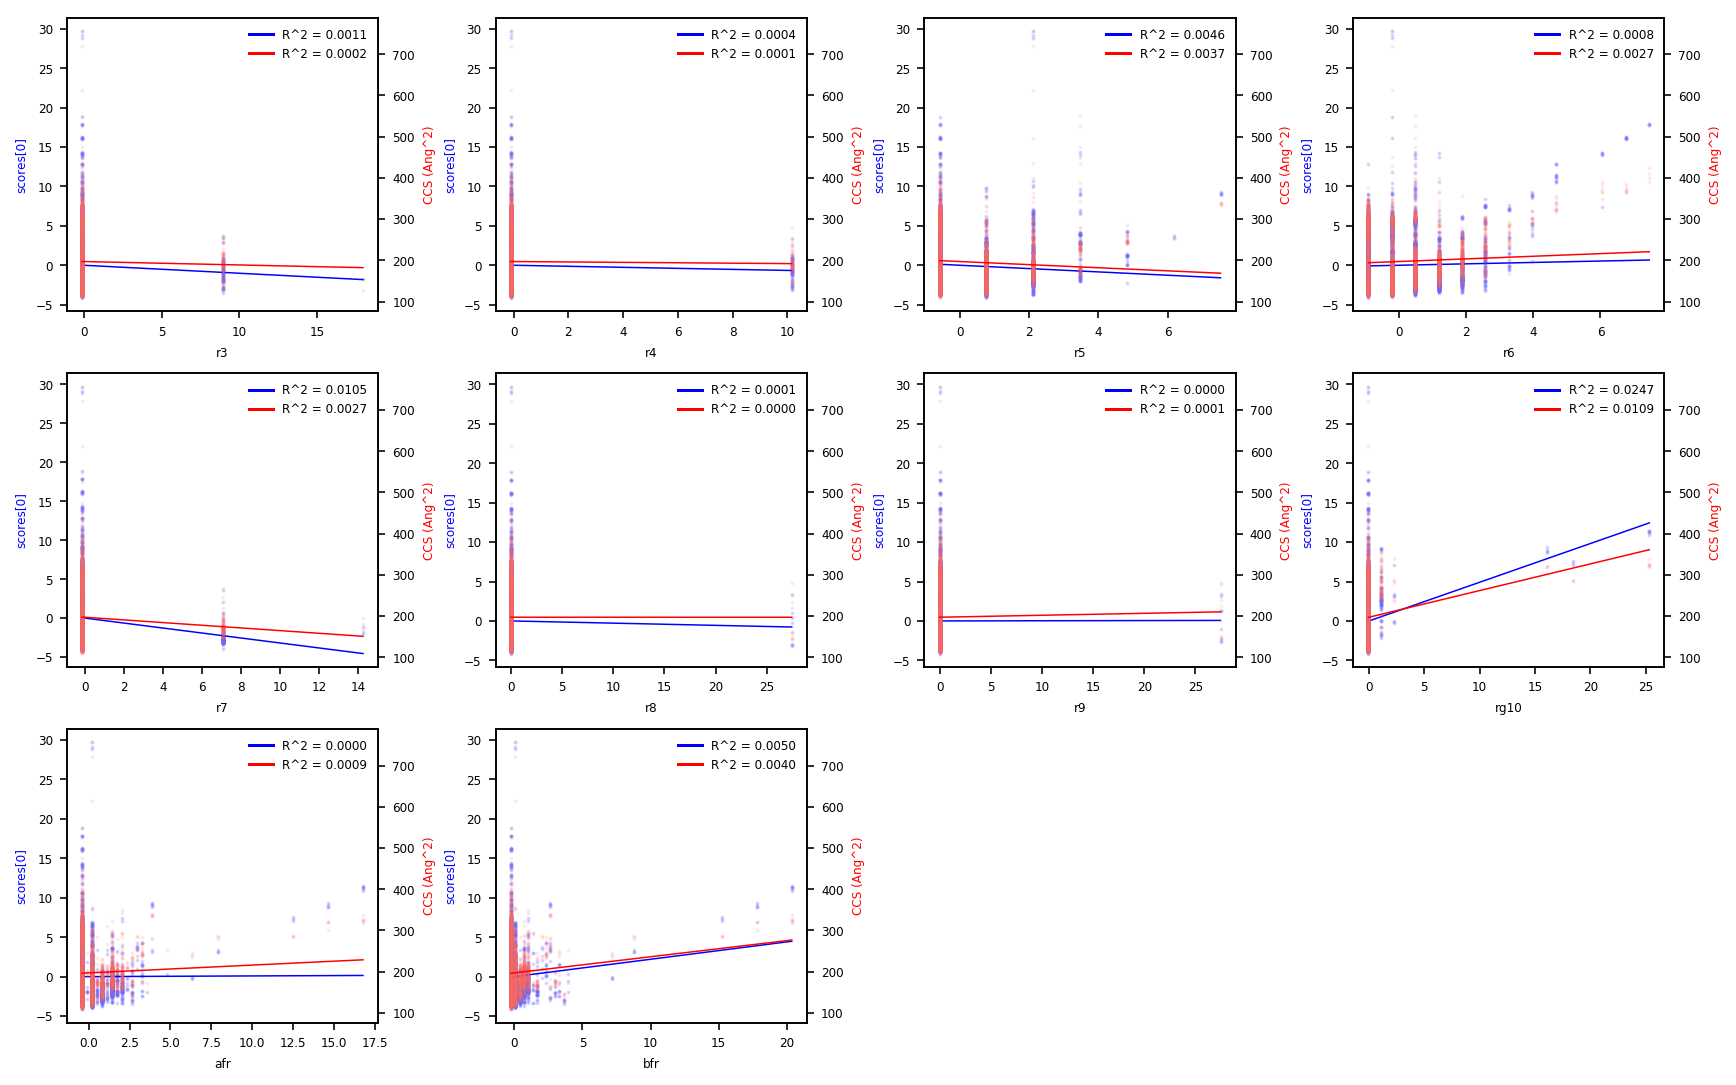

In [69]:
# the remaining MQNs vs. scores[0] and CCS
fig = plt.figure(figsize=(12, 7.5))

for i in range(4):
    for j in range(4): 
        if i < 2 or (i == 2 and j < 2):
            idx = j + 4 * i + 40
            
            x_tmp = [_[idx] for _ in X_scaled]
            m1, b1, r_value1, *_ = linregress(x_tmp, plsr.x_scores_.T[0])
            ax = plt.subplot2grid((3, 4), (i, j))
            axt = ax.twinx()
            ax.scatter(x_tmp, plsr.x_scores_.T[0], c='#6666FF', s=1, alpha=0.2)
            ax.plot([min(x_tmp), max(x_tmp)], [m1 * min(x_tmp) + b1, m1 * max(x_tmp) + b1], 'b-', lw=0.75)
            m2, b2, r_value2, *_ = linregress(x_tmp, c3sd.y_)
            axt.scatter(x_tmp, c3sd.y_, c='#FF6666', s=1, alpha=0.1)
            axt.plot([min(x_tmp), max(x_tmp)], [m2 * min(x_tmp) + b2, m2 * max(x_tmp) + b2], 'r-', lw=0.75)
            ax.set_xlabel(md_id[idx])
            ax.set_ylabel('scores[0]', color='b')
            axt.set_ylabel('CCS (Ang^2)', color='r')
            ax.legend([mlines.Line2D([], [], color='b'), mlines.Line2D([], [], color='r')], 
                      ['R^2 = {:.4f}'.format(r_value1**2.), 'R^2 = {:.4f}'.format(r_value2**2.)], 
                      frameon=False)

plt.tight_layout()
plt.show()


Among the final 10 MDs, there is little evidence for strong contributions to the distribution of CCS values.

### Conclusion
??
